Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 4 </h2>
    <h1> Clustering, Asociaciones y Redes Bayesianas </h1>
    <h1>Vicente Lavagnino</h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Primer Semestre 2025<br>    
        Fecha de entrega: 23 de mayo
    </p>
    <br>
</center>

<br>

---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

A continuación se encuentran las librerías necesarias para elaborar la tarea. Recuerda ejecutar la celda antes de comenzar.

In [1]:
!pip install pgmpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from umap import UMAP

from pgmpy.inference import VariableElimination
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BDs

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Contexto

Un empresario multimillonario acaba de comprar un club de fútbol de las 5 mejores ligas del mundo y te ha contactado a ti como experto en Mineria de Datos para que lo ayudes a saber como llevar a su nuevo equipo a los primeros lugares. Para conseguir lo anterior te ha entregado datos de la temporada 2015-2016 de la Bundelisga (Alemania), La Liga (España), Ligue 1 (Francia), Premier League (Inglaterra) y Serie A (Italia) con las estadísticas de los equipos que participaron en esa temporada en sus respectivas ligas para poder encontrar estilos de juegos que le puedan servir para replicar en su nuevo equipo.

## 1. Carga y Preprocesamiento de Datos (5 Pts.)

### 1.1 Cargar Datos

Cargue el dataset `teams.csv`. Indique la cantidad de filas y columnas del conjunto de datos. ¿Existen datos nulos? De ser así, mencione el número de casos por variable y luego elimine todas filas que tengan a lo menos un valor nulo.

In [6]:
# Cargamos el dataset
teams = pd.read_csv("teams.csv")
teams.head()

,Unnamed: 0,team,total_shots,onTarget,goals,xG_total,Shot_to_goal_ratio,Shot_onTarget_to_goal_ratio,xG/shot,recoveries,...,ppda,total_passes,f3_passes,short_passes,long_passes,average_pass_length,crosses,ranking,points_per_match,groups
0,0,Real Madrid,717,287,108,80.794913,15.062762,37.630662,0.112685,1715,...,12.785114,23279,2225,15556,2388,18.465597,683,2,2.37,1
1,1,Napoli,664,244,78,64.630668,11.746988,31.967213,0.097335,1847,...,13.472731,26906,2671,18602,2099,16.582880,519,2,2.16,1
2,2,Tottenham Hotspur,656,249,68,62.356203,10.365854,27.309237,0.095055,1976,...,10.571661,20624,2527,11906,2577,20.121036,431,3,1.84,1
3,3,Liverpool,635,203,62,58.373657,9.763780,30.541872,0.091927,1999,...,10.999069,21464,2427,12984,2298,18.959322,511,8,1.58,2
4,4,Bayern Munich,622,258,78,73.353521,12.540193,30.232558,0.117932,1604,...,11.116863,25862,2633,18128,2090,18.200877,561,1,2.59,1


In [7]:
print(f"Cantidad de filas: {teams.shape[0]}")
print(f"Cantidad de columnas: {teams.shape[1]}")
print(f"Existen datos nulos: {teams.isnull().any().any()}")
if teams.isnull().any().any():
    print(f"Número de casos por variable:")
    for column in teams.columns:
        print(f"{column}: {teams[column].isnull().sum()}")

Cantidad de filas: 78
Cantidad de columnas: 28
Existen datos nulos: False


*Respuesta:*

- El dataset tiene 78 filas y 28 columnas.
- No existen datos nulos, por lo que no es necesario eliminar filas.

### 1.2 Descripción del dataset (1 Pts.)

Describa brevemente cuantas columnas tiene el dataset y defina que significa cada columna del dataset. Para lo anterior te puedes apoyar de las siguientes páginas webs:

- [Definición Métricas Opta](https://theanalyst.com/2024/07/opta-football-stats-definitions)
- [Explicación xG Opta](https://theanalyst.com/2023/08/what-is-expected-goals-xg)
- [Definición Métricas StatsPerform](https://www.statsperform.com/opta-event-definitions/)
- [Glosario WhoScored](https://www.whoscored.com/glossary)

In [11]:
print(f"Cantidad de columnas: {teams.shape[1]}")

# nombre de las columnas
for column in teams.columns:
    print(column)


Cantidad de columnas: 28
Unnamed: 0
team
total_shots
onTarget
goals
xG_total
Shot_to_goal_ratio
Shot_onTarget_to_goal_ratio
xG/shot
recoveries
recoveries_f3
duels_won
fouls_committed
shots_against
shots_onTarget_against
xGA
goals_against
clean_sheets
ppda
total_passes
f3_passes
short_passes
long_passes
average_pass_length
crosses
ranking
points_per_match
groups


**Respuesta:**

El dataset tiene 28 columnas. Las cuales son:

1. **Unnamed: 0**: Corresponde al índice del dataframe.
2. **team**: Nombre del equipo.
3. **total_shots**: Número total de tiros realizados.
4. **onTarget**: Tiros que fueron al arco.
5. **goals**: Goles anotados.
6. **xG_total**: Goles esperados por el equipo, estimados en base a proporciones similares de tiros en el pasado.
7. **Shot_to_goal_ratio**: Proporción en tiros totales por cada gol.
8. **Shot_onTarget_to_goal_ratio**: Proporción en tiros al arco por cada gol.
9. **xG/shot**: Goles esperados promedio por tiro.
10. **recoveries**: Número de recuperaciones de la pelota.
11. **recoveries_f3**: Recuperaciones en el último tercio de la cancha.
12. **duels_won**: Partidos ganados.
13. **fouls_committed**: Faltas cometidas por el equipo.
14. **shots_against**: Tiros recibidos en contra.
15. **shots_onTarget_against**: Tiros al arco recibidos en contra.
16. **xGA**: Goles esperados en contra, usando la métrica xG del rival.
17. **goals_against**: Goles recibidos.
18. **clean_sheets**: Partidos sin goles en contra.
19. **ppda**: Pases del rival permitidos antes de hacer una acción defensiva.
20. **total_passes**: Pases totales completados.
21. **f3_passes**: Pases completados en el último tercio de la cancha.
22. **short_passes**: Pases cortos completados.
23. **long_passes**: Pases largos completados.
24. **average_pass_length**: Longitud promedio de los pases.
25. **crosses**: Centros o balones cruzados al área rival.
26. **ranking**: Posición final del equipo en la liga.
27. **points_per_match**: Puntos promedio obtenidos por partido.
28. **groups**: Grupo al que pertenece el equipo en la competición.

### 1.3 Normalización (1 Pts.)

Realice el proceso de normalización sobre la matriz de variables explicativas utilizando el método StandardScaler. A partir de aquí, tiene que usar esta matriz para los experimentos. Para lo anterior, elimine las columnas `team`, `ranking`, `points_per_match` y `groups`, pero mantenga una copia del dataframe original, ya que lo necesitaras en secciones posteriores.

In [12]:
# Creamos un dataframe con los datos originales
teams_original = teams.copy()

# Eliminamos las columnas especificadas
teams_scaled = teams.drop(columns=['team', 'ranking', 'points_per_match', 'groups'])

# Normalizamos la matriz de variables explicativas con StandardScaler
scaler = StandardScaler()
teams_scaled_values = scaler.fit_transform(teams_scaled)

# Creamos un nuevo dataframe con los datos normalizados
teams_scaled_df = pd.DataFrame(teams_scaled_values, columns=teams_scaled.columns)

# Vemos las primeras filas
print(teams_scaled_df.head())

   Unnamed: 0  total_shots  onTarget     goals  xG_total  Shot_to_goal_ratio  \
0   -1.709986     3.080068  3.488623  3.734441  2.876468            2.465554   
1   -1.665570     2.410650  2.305046  1.848685  1.481221            0.806010   
2   -1.621155     2.309606  2.442671  1.220100  1.284897            0.114752   
3   -1.576740     2.044364  1.176519  0.842949  0.941136           -0.186586   
4   -1.532325     1.880168  2.690397  1.848685  2.234151            1.203009   

   Shot_onTarget_to_goal_ratio   xG/shot  recoveries  recoveries_f3  ...  \
0                     1.844636  0.935657   -0.671575       0.779547  ...   
1                     0.482729 -0.189026    0.260806       0.851018  ...   
2                    -0.637389 -0.356099    1.171996       1.780152  ...   
3                     0.139973 -0.585307    1.334456       1.261981  ...   
4                     0.065591  1.320120   -1.455622       0.440056  ...   

        xGA  goals_against  clean_sheets      ppda  total_pass

**Respuesta:**

Se realizó el proceso de normalización sobre la matriz de variables explicativas utilizando el método `StandardScaler`. Para esto, se eliminaron las columnas `team`, `ranking`, `points_per_match` y `groups`.

Se creó un nuevo dataframe llamado `teams_scaled_df` con las variables normalizadas.

### 1.4 Matriz de correlación (2 Pts.)

A partir del dataframe normalizado en la sección anterior construya la matriz de correlación. ¿Que variables tienen alta correlación ($> 0.8$)?

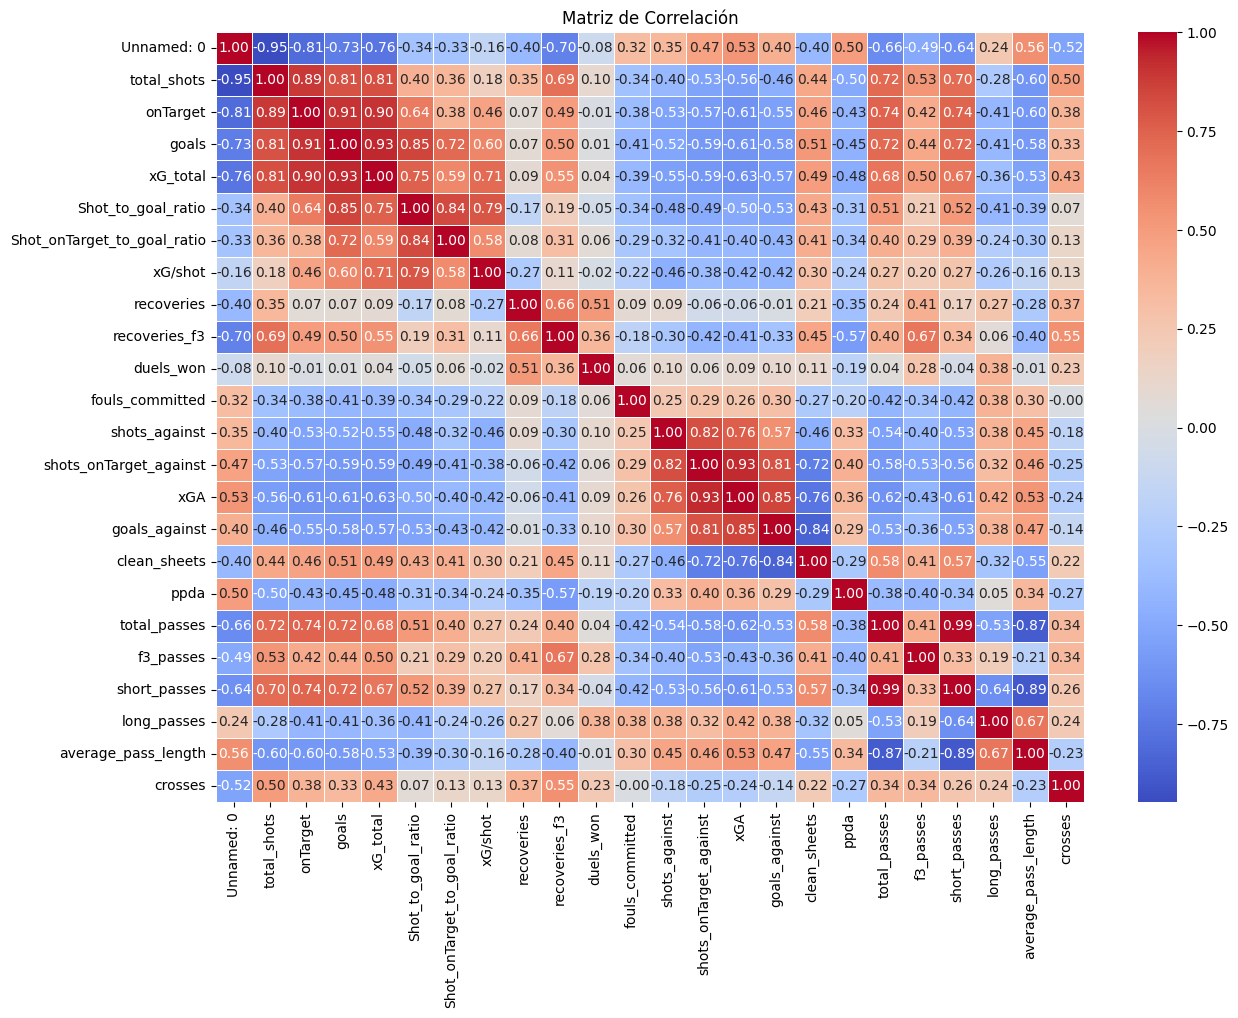

Pares de variables con correlación mayor a 0.8 (+ o -):
Unnamed: 0 - total_shots: -0.9476482849490907
Unnamed: 0 - onTarget: -0.8053656265316431
total_shots - onTarget: 0.8868041502803351
total_shots - goals: 0.8083036553404781
total_shots - xG_total: 0.8131215690368849
onTarget - goals: 0.9070866061384665
onTarget - xG_total: 0.902342903071497
goals - xG_total: 0.9337588519773445
goals - Shot_to_goal_ratio: 0.8528471101604511
Shot_to_goal_ratio - Shot_onTarget_to_goal_ratio: 0.838882071003541
shots_against - shots_onTarget_against: 0.821195666283005
shots_onTarget_against - xGA: 0.9259990502597336
shots_onTarget_against - goals_against: 0.8059011429021844
xGA - goals_against: 0.8496044551859033
goals_against - clean_sheets: -0.8437143781628182
total_passes - short_passes: 0.986197297126906
total_passes - average_pass_length: -0.8737718992600738
short_passes - average_pass_length: -0.8935660533598884


In [17]:
# Calculamos la matriz de correlación
correlation_matrix = teams_scaled_df.corr()

# Hacemos la matriz de correlación de manera visual
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Variables con correlación mayor a 0.8 (en valor absoluto)
high_correlation = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_correlation.append((var1, var2, corr_value))

# Imprimimos las variables con correlación mayor a 0.8
print("Pares de variables con correlación mayor a 0.8 (valor absoluto):")
for var1, var2, corr_value in high_correlation:
    print(f"{var1} - {var2}: {corr_value}")


**Respuesta:**

Se construyó la matriz de correlación del dataframe normalizado. Las siguientes variables presentan una alta correlación (mayor a 0.8 en valor absoluto):

Donde luego podemos ver en el output que las variables con correlación mayor a 0.8 está en el print anterior.

Esto indica que estas variables tienen una relación lineal fuerte (positiva o negativa) y deben considerarse cuidadosamente en los análisis posteriores.

## 2. Clustering (15 Pts.)

### 2.1 K-Means (5 Pts.)

#### 2.1.1 Explicación teórica (2 Pts.)

Investigue sobre `K-means` y entregue una explicación de como funciona. `No es necesario una explicación matemática`. Se espera que tu explicación contenga la respuesta a las siguientes preguntas:
1. ¿Qué tipo de algoritmo es?
2. ¿Para qué sirve?
3. ¿Cómo funciona?
4. ¿Qué es un centroide?
5. ¿Que es la inercia en este contexto?

**❗IMPORTANTE❗** No utilices ChatGPT u otro modelo de lenguaje para responder esta pregunta. Será evaluado que cites al menos 1 recurso bibliográfico que hayas utilizado. Cualquier información que no tenga una referencia clara no se le dará puntaje.

**Respuesta:**

1. K-Means es un algoritmo de aprendizaje no supervisado que se utiliza para agrupar datos en distintos "clusters" o grupos. Según IBM, es uno de los métodos más populares para descubrir patrones en datos sin etiquetar, ayudando a simplificar y organizar la información.

2. Este algoritmo tiene como objetivo identificar patrones y agrupar datos similares en clusters, lo que permite extraer estructuras significativas o comportamientos comunes en grandes volúmenes de datos (IBM). Por ejemplo, se usa comúnmente en análisis de mercado, segmentación de clientes o compresión de datos.

3. El funcionamiento de K-Means implica elegir al azar `k` puntos llamados centroides, que representan el centro de cada cluster (GeeksforGeeks). Después, cada punto de datos se asigna al centroide más cercano. Una vez formados los clusters, los centroides se actualizan como el promedio de los puntos asignados a cada grupo. Este proceso se repite hasta que los centroides dejan de cambiar significativamente o se alcanza el número máximo de iteraciones.

4. Un centroide es el punto medio o de referencia de un cluster, que representa la media de todas las observaciones asignadas a ese grupo (IBM México)

5. En este contexto, la inercia mide la compacidad de los clusters. Específicamente, la inercia mide qué tan bien se agrupa un conjunto de datos mediante K-Means. Se calcula midiendo la distancia entre cada punto de datos y su centroide, elevando esta distancia al cuadrado y sumando estos cuadrados en un grupo. (CodeAcademy)

Referencias:

- IBM: https://www.ibm.com/think/topics/k-means-clustering  
- IBM México: https://www.ibm.com/mx-es/think/topics/k-means-clustering  
- Scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- GeeksforGeeks: https://www.geeksforgeeks.org/k-means-clustering-introduction/
- CodeAcademy: https://www.codecademy.com/learn/dspath-unsupervised/modules/dspath-clustering/cheatsheet?_x_tr_hist=true

#### 2.1.2 Número de clusters (2 Pts.)

La libreria [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) tiene implementado este algoritmo. Grafique los valores de *inertia* y silhoutte score para un rango de 2 a 10 clusters. Determine el número óptimo de clusters.

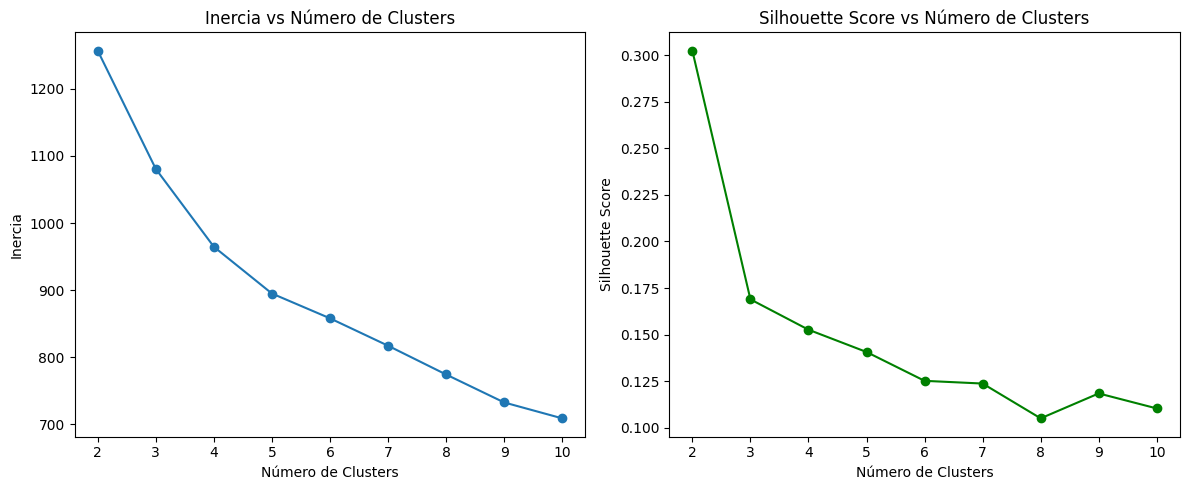

Número óptimo de clusters en base al silhouette score: 2


In [21]:
clusters_range = range(2, 11)
inertia_values = []
silhouette_scores = []

# Probamos distintos valores de clusters
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(teams_scaled_df)
    inertia_values.append(kmeans.inertia_)
    
    # Calculamos el silhouette score
    score = silhouette_score(teams_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Graficamos la inercia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(clusters_range, inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Inercia vs Número de Clusters')

# Graficamos el silhouette score
plt.subplot(1, 2, 2)
plt.plot(clusters_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Número de Clusters')

plt.tight_layout()
plt.show()

# Determinamos el número óptimo de clusters (máximo silhouette score)
k_optimo = clusters_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Número óptimo de clusters en base al silhouette score: {k_optimo}")

**Respuesta:**

Se graficaron los valores de **inercia** y **silhouette score** para el rango de 2 a 10 clusters. Según el resultado del **silhouette score**, el número óptimo de clusters es `k=2`, ya que presenta el valor más alto de silhouette score, sin embargo si utilizamos el método del códo, podemos decir que `k=4 o 5` también puede ser un buen número, de todas maneras como no existe un codo tan marcado en el primer gráfico, priorizaremos el valor de `k=2` para el análisis en base al resultado del silhouette score.

#### 2.1.3 Ejecutar K-Means (1 Pts.)

**Ejecute K-Means con un número de clusters igual a 4.** Una vez obtenidos los clusters imprima las posiciones en que terminaron esos equipos:

- ¿Existe alguna relación entre los clusters obtenidos y la posición que obtuvieron los equipos de ese cluster respectivo?
- Describa cada cluster según la posición de los clubes dentro de los clusters y otras estadísticas presentes en el dataset.

Finalmente, calcule *silhouette score* con los valores escogidos.

In [47]:
# Ejecutamos K-Means con 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(teams_scaled_df)

# Creamos un nuevo dataframe con la columna de clusters
teams_clusters = teams.copy()
teams_clusters['cluster'] = labels_4

# Imprimimos la información
print("Equipos, posiciones finales y clusters asignados")
equipos_clusters = teams_clusters[['cluster', 'ranking', 'team', 'points_per_match']].sort_values(by=['cluster', 'ranking'])
print(equipos_clusters.to_string(index=False))

# Calculamos el silhouette score para k=4
sil_4 = silhouette_score(teams_scaled_df, labels_4)
print(f"Silhouette score para k=4: {sil_4}")

Equipos, posiciones finales y clusters asignados
 cluster  ranking                     team  points_per_match
       0        1           Leicester City              2.13
       0        3         Bayer Leverkusen              1.76
       0        4              Inter Milan              1.76
       0        5            Athletic Club              1.63
       0        5        Manchester United              1.74
       0        6              Southampton              1.66
       0        6                 Sassuolo              1.61
       0        6               Celta Vigo              1.58
       0        7                 AC Milan              1.50
       0        7          West Ham United              1.63
       0        7                  Sevilla              1.37
       0        8                    Lazio              1.42
       0        8                   Málaga              1.26
       0        9            Real Sociedad              1.26
       0       10                  C

In [27]:
# Vemos un resumen de estadísticas por cluster
print("Resumen por cluster")
cluster_summary = teams_clusters.groupby('cluster').agg(n_equipos=('team', 'count'), ranking_promedio=('ranking', 'mean'), ranking_min=('ranking', 'min'), ranking_max=('ranking', 'max'), goles_promedio=('goals', 'mean'), xG_promedio=('xG_total', 'mean'), goles_en_contra=('goals_against', 'mean'), puntos_promedio=('points_per_match', 'mean')).round(2)
print(cluster_summary)

Resumen por cluster
         n_equipos  ranking_promedio  ranking_min  ranking_max  \
cluster                                                          
0               19              7.37            1           16   
1               27             15.52            9           20   
2               13              2.85            1            8   
3               19             10.79            4           18   

         goles_promedio  xG_promedio  goles_en_contra  puntos_promedio  
cluster                                                                 
0                 50.47        49.59            45.16             1.49  
1                 38.07        40.38            58.56             1.04  
2                 76.23        66.79            31.69             2.10  
3                 42.74        42.22            49.42             1.24  


**Respuesta:**

Ejecutamos K-Means con `k=4` y tenemos un **silhouette score de 0.153**, que muestra una separación moderada entre los clusters.

En ese sentido, vemos una relación clara con los resultados de la tabla de posiciones:
- **Cluster 2** tiene a los equipos con mejor desempeño, con más goles y menos goles en contra.  
- **Cluster 1** junta a los de la parte baja de la tabla, con menos puntos y más goles recibidos.  
- **Clusters 0 y 3** agrupan equipos de media tabla.

Aunque el silhouette no es alto, los promedios de goles y puntos muestran diferencias claras entre los grupos. Así que los clusters reflejan bien el rendimiento de los equipos.

### 2.2 DBSCAN (5 Pts.)

Usando *k-dist plot* para MinPts=3, encuentre que rango de EPS deberiamos evaluar. Una vez obtenidos los clusters realice el mismo análisis de la sección anterior:

- ¿Existe alguna relación entre los clusters obtenidos y la posición que obtuvieron los equipos de ese cluster respectivo?
- Describa cada cluster según la posición de los clubes dentro de los clusters y otras estadísticas presentes en el dataset.

Finalmente, calcule *silhouette score* con los valores escogidos

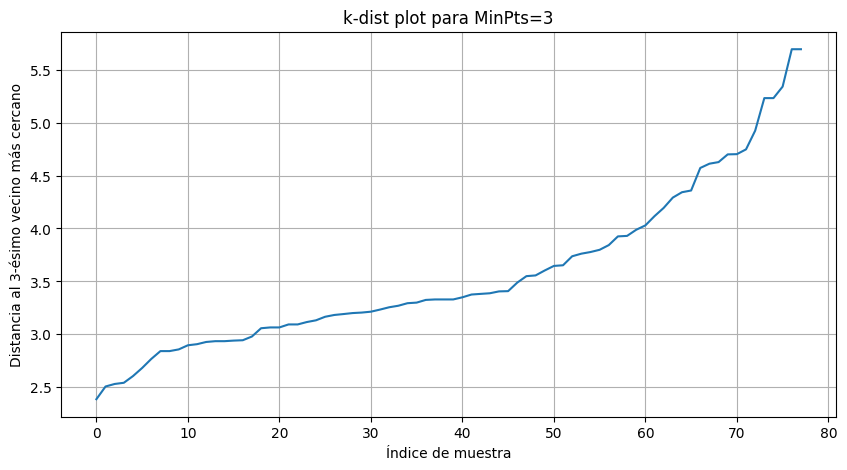

In [33]:
# Usamos k-dist plot con MinPts=3
k = 3
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(teams_scaled_df)
distances, indices = neighbors_fit.kneighbors(teams_scaled_df)

# Ordenamos las distancias al vecino más lejano para cada punto
distances = np.sort(distances[:, k-1])

# Graficamos el k-dist plot
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel('Índice de muestra')
plt.ylabel(f'Distancia al 3-ésimo vecino más cercano')
plt.title('k-dist plot para MinPts=3')
plt.grid(True)
plt.show()


In [39]:
eps_val = 3.7

# Ejecutamos DBSCAN
dbscan = DBSCAN(eps=eps_val, min_samples=3)
labels_dbscan = dbscan.fit_predict(teams_scaled_df)

# Creamos un nuevo dataframe con los clusters
teams_clusters_db = teams.copy()
teams_clusters_db['cluster'] = labels_dbscan

# Vemos qué equipos quedaron en cada cluster
print("Equipos y posiciones finales por cluster:")
equipos_clusters_db = teams_clusters_db[['cluster', 'ranking', 'team', 'points_per_match']].sort_values(by=['cluster', 'ranking'])
print(equipos_clusters_db.to_string(index=False))


sil_dbscan = silhouette_score(teams_scaled_df, labels_dbscan)
print(f"Silhouette score para DBSCAN (eps={eps_val}): {sil_dbscan:.3f}")

Equipos y posiciones finales por cluster:
 cluster  ranking                     team  points_per_match
      -1        1            Bayern Munich              2.59
      -1        1                 Juventus              2.39
      -1        1                Barcelona              2.39
      -1        2              Real Madrid              2.37
      -1        2                   Napoli              2.16
      -1        2        Borussia Dortmund              2.29
      -1        3                  AS Roma              2.11
      -1        3          Atlético Madrid              2.32
      -1        4 Borussia Mönchengladbach              1.62
      -1        6               Celta Vigo              1.58
      -1        7                  Sevilla              1.37
      -1        8                Wolfsburg              1.32
      -1       10                   Empoli              1.21
      -1       11               Ingolstadt              1.18
      -1       14                    Eibar 

In [37]:
# Resumen de estadísticas por cluster
print("Resumen por cluster:")
cluster_summary_db = teams_clusters_db.groupby('cluster').agg(n_equipos=('team', 'count'), ranking_promedio=('ranking', 'mean'), ranking_min=('ranking', 'min'), ranking_max=('ranking', 'max'), goles_promedio=('goals', 'mean'), xG_promedio=('xG_total', 'mean'), goles_en_contra=('goals_against', 'mean'), puntos_promedio=('points_per_match', 'mean')).round(2)
print(cluster_summary_db)

Resumen por cluster:
         n_equipos  ranking_promedio  ranking_min  ranking_max  \
cluster                                                          
-1              19              7.63            1           20   
 0              59             11.12            1           20   

         goles_promedio  xG_promedio  goles_en_contra  puntos_promedio  
cluster                                                                 
-1                60.32        55.27            43.84             1.65  
 0                44.81        44.96            50.12             1.29  


**Respuesta:**

Usamos el k-dist plot con MinPts=3 y  un rango de EPS alrededor de 3.5 a 4 (por el “codo” donde la curva sube rápido). Finalmente, decidimos usar EPS=3.7 Donde para este caso se tiene un Silhouette score de 0.177.


En cuanto a la relación con las posiciones finales, tenemos:
- Cluster -1 reúne a los equipos con mejor rendimiento (19 equipos, los con mejor ranking, menos goles en contra y más puntos), donde se incluyen a los equipos  como Bayern, Juventus, Real Madrid, etc.  
- Cluster 0 agrupa a la mayoría de los equipos (59 equipos), con ranking promedio más bajo y peores resultados en general.

En resumen, los clusters captan bien la diferencia de rendimiento entre los mejores equipos y el resto. Aunque DBSCAN dejó muchos equipos juntos en el cluster 0, logra separar a los mejores equipos de los peores con precisión.

### 2.3 GMM (5 Pts.)

#### 2.3.1 Explicación AIC (2 Pts.)

Investigue sobre las métricas `AIC`, y conteste las siguientes preguntas:

- ¿Qué es la métrica `AIC`?
- ¿Qué penaliza esta métrica?
- ¿Qué casos de usos tiene esta métrica?
- Para el caso de GMM, ¿se busca maximizar o minimizar esta métrica? ¿Por qué?

**❗IMPORTANTE❗** No utilices ChatGPT u otro modelo de lenguaje para responder esta pregunta. Será evaluado que cites al menos 1 recurso bibliográfico que hayas utilizado. Cualquier información que no tenga una referencia clara no se le dará puntaje.

**Respuesta:**

El criterio de información de Akaike (AIC) es un método matemático para evaluar el ajuste de un modelo a los datos a partir de los cuales se generó. En estadística, el CAI se utiliza para comparar diferentes modelos posibles y determinar cuál se ajusta mejor a los datos.(https://www.scribbr.com/statistics/akaike-information-criterion/).

AIC trabaja evaluando el modelo encaja en los datos de formación y añadiendo un plazo de penalización para la complejidad del modelo (fundamentos similares a la regularización). El resultado deseado es encontrar el AIC más bajo posible, que indica el mejor equilibrio del modelo encaja con la generalización. Esto sirve al objetivo final de maximizar el ajuste en los datos fuera de la muestra. Sin embargo, es importante comparar los modelos que están cerca en valor AIC para asegurarse de que se está haciendo la mejor selección de modelos.(https://builtin.com/data-science/what-is-aic).

El AIC se usa principalmente para la comparación de modelos (como por ejemplo redes neuronales o GMM). Permite identificar el modelo que ofrece el mejor equilibrio entre ajuste y simplicidad (https://jrubalcaba.github.io/posts/information_criterion/).

En el caso de los modelos GMM, se busca minimizar el AIC, mientras más bajo es el AIC, mejor es el equilibrio entre la complejidad y el ajuste, y por lo tanto mejor es el modelo (https://medium.com/gopenai/gaussian-mixture-models-gmm-explained-a-complete-guide-with-python-examples-2d07185687fc).

#### 2.3.2 Obtener AIC (1 Pts.)

Determine el número óptimo de componentes para el modelo Gaussian Mixture Model utilizando la métrica AIC. Considere un rango de número de componentes entre 1 y 40.

Luego, grafique la curva entre número de componentes y la métrica AIC

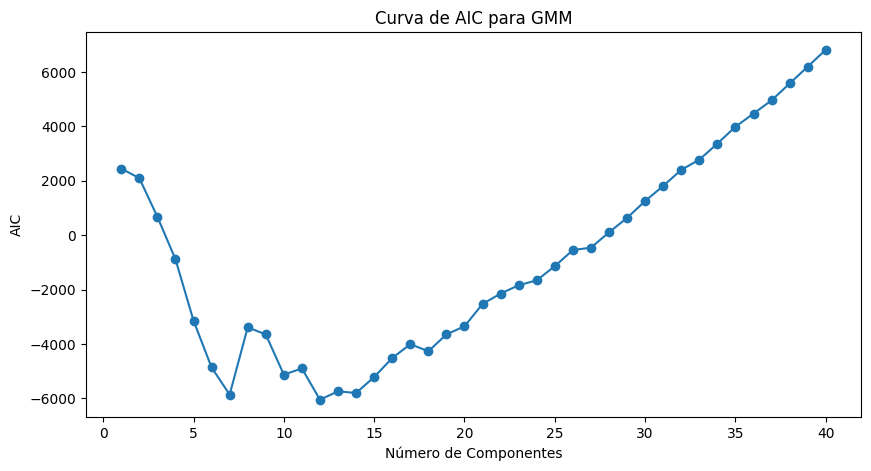

El número de componentes óptimo es 12, con un AIC de -6049.194860599151


In [42]:
# Determinamos el número de componentes óptimo para GMM
n_components_range = range(1, 41)
aic_values = []

# Calculamos el AIC para cada número de componentes
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(teams_scaled_df)
    aic = gmm.aic(teams_scaled_df)
    aic_values.append(aic)

# Graficamos la curva de AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, aic_values, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('AIC')
plt.title('Curva de AIC para GMM')
plt.show()

print(f"El número de componentes óptimo es {n_components_range[aic_values.index(min(aic_values))]}, con un AIC de {min(aic_values)}")

**Respuesta:**

Probamos el modelo GMM para un rango de 1 a 40 componentes. Se graficó el AIC para cada modelo y se encontró que el número óptimo de componentes es 12 con un AIC mínimo de -6049.19. Lo que indica que con 12 componentes, el GMM logra el mejor equilibrio entre el ajuste a los datos y la complejidad del modelo

#### 2.3.3 Implementación GMM (2 Pts.)

Escoja el número de componentes que minimiza AIC para entrenar GMM. Una vez obtenidos los clusters realice el mismo análisis de la sección anterior:

- ¿Existe alguna relación entre los clusters obtenidos y la posición que obtuvieron los equipos de ese cluster respectivo?
- Describa cada cluster según la posición de los clubes dentro de los clusters y otras estadísticas presentes en el dataset.

Finalmente, calcule *silhouette score* con los valores escogidos.

In [44]:
# Entrenamos el modelo GMM con el número de componentes óptimo
gmm = GaussianMixture(n_components=12, random_state=42)
gmm.fit(teams_scaled_df)

# Obtenemos las etiquetas de los clusters
labels_gmm = gmm.predict(teams_scaled_df)

# Creamos un nuevo dataframe con los clusters
teams_clusters_gmm = teams.copy()
teams_clusters_gmm['cluster'] = labels_gmm

# Vemos cuales equipos quedaron en cada cluster
print("Equipos y posiciones finales por cluster:")
equipos_clusters_gmm = teams_clusters_gmm[['cluster', 'ranking', 'team', 'points_per_match']].sort_values(by=['cluster', 'ranking'])
print(equipos_clusters_gmm.to_string(index=False))

# Calculamos silhouette score
sil_gmm = silhouette_score(teams_scaled_df, labels_gmm)
print(f"Silhouette score para GMM (12 componentes): {sil_gmm}")


Equipos y posiciones finales por cluster:
 cluster  ranking                     team  points_per_match
       0       10                  Chelsea              1.32
       0       10                   Empoli              1.21
       0       11                  Everton              1.24
       0       11               Las Palmas              1.16
       0       12             Swansea City              1.24
       0       16          AFC Bournemouth              1.11
       1        1                 Juventus              2.39
       1        3          Atlético Madrid              2.32
       1        5               Fiorentina              1.68
       2        9                   Chievo              1.32
       2       10               Real Betis              1.18
       2       13                 Atalanta              1.18
       2       14                  Bologna              1.11
       2       15           Crystal Palace              1.11
       2       16                  Palermo 

In [45]:
# Resumen por cluster
print("Resumen por cluster:")
cluster_summary_gmm = teams_clusters_gmm.groupby('cluster').agg(n_equipos=('team', 'count'), ranking_promedio=('ranking', 'mean'), ranking_min=('ranking', 'min'), ranking_max=('ranking', 'max'), goles_promedio=('goals', 'mean'), xG_promedio=('xG_total', 'mean'), goles_en_contra=('goals_against', 'mean'), puntos_promedio=('points_per_match', 'mean')).round(2)
print(cluster_summary_gmm)

Resumen por cluster:
         n_equipos  ranking_promedio  ranking_min  ranking_max  \
cluster                                                          
0                6             11.67           10           16   
1                3              3.00            1            5   
2               14             16.36            9           20   
3                4              5.25            4            7   
4                7              6.71            3           11   
5                3              1.33            1            2   
6                2              2.50            2            3   
7                6              5.50            1            9   
8                9             11.89            5           18   
9               12             13.67            6           18   
10               5              3.80            2            8   
11               7             13.29            9           17   

         goles_promedio  xG_promedio  goles_en_contra 

**Respuesta:**

Entrenamos el modelo GMM con el número óptimo de componentes (12). Donde obtenemos un silhouette score de 0.113, lo que indica que hay cierta diferenciación entre los clusters, aunque no es muy fuerte.

En cuanto a la relación con las posiciones finales, tenemos que los clusters muestran patrones que reflejan el rendimiento de los equipos:
- Clusters 5 y 6: Agrupan a los mejores equipos.
- Clusters 1, 4 y 10: Incluyen a los equipos con rendimiento alto-medio.
- Clusters 2, 9 y 11: Reúnen a los equipos de menor rendimiento, con menos goles y peores resultados.
- Clusters 0, 3, 7 y 8: Equipos de medianos, combinando características intermedias en goles, xG y puntos.

Aunque el silhouette no es alto, estos clusters permiten ver agrupaciones y reflejan de manera general la posición de los equipos y su rendimiento.

## 3. Visualización (10 Pts.)

En esta sección se espera que grafiques los datos coloreados según su cluster utilizando PCA, t-SNE y UMAP.

### 3.1 PCA n=2 (3 Pts.)

Realiza una gráfica de PCA con 2 componentes coloreando cada dato según su cluster para los resultados obtenidos con K-Means, DBSCAN y GMM.

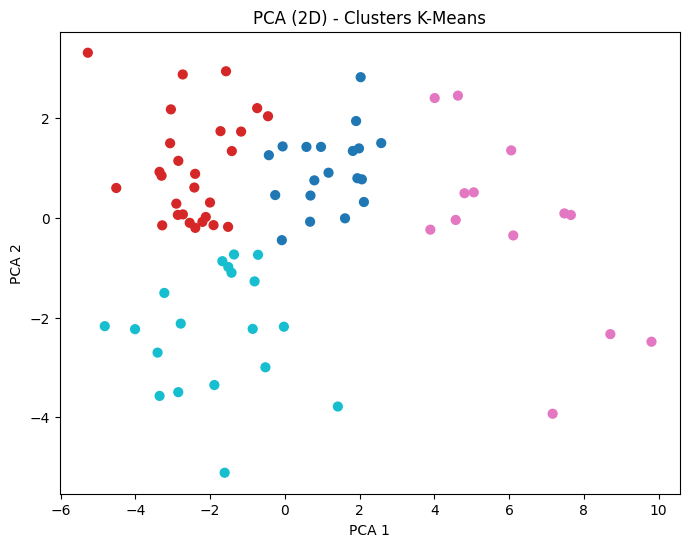

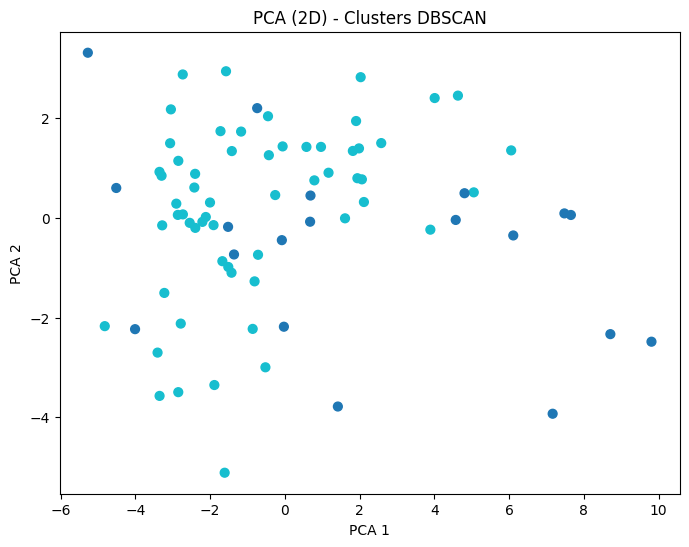

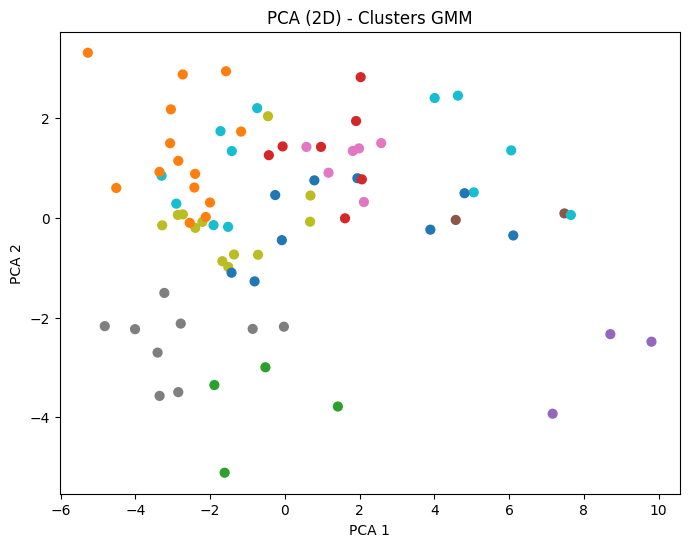

In [49]:
# Ejecutamos PCA para 2 componentes
pca = PCA(n_components=2)
teams_pca = pca.fit_transform(teams_scaled_df)

# Creamos un dataframe para graficar
df_pca = pd.DataFrame(teams_pca, columns=['PCA1', 'PCA2'])
df_pca['KMeans'] = teams_clusters['cluster']
df_pca['DBSCAN'] = teams_clusters_db['cluster']
df_pca['GMM'] = teams_clusters_gmm['cluster']

# Gráfico para K-Means
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['KMeans'], cmap='tab10', s=40)
plt.title('PCA (2D) - Clusters K-Means')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Gráfico para DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['DBSCAN'], cmap='tab10', s=40)
plt.title('PCA (2D) - Clusters DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Gráfico para GMM
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['GMM'], cmap='tab10', s=40)
plt.title('PCA (2D) - Clusters GMM')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

### 3.2 t-SNE (2 Pts)

Realiza una gráfica de t-SNE con 2 componentes coloreando cada dato según su cluster para los resultados obtenidos con K-Means, DBSCAN y GMM.

/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


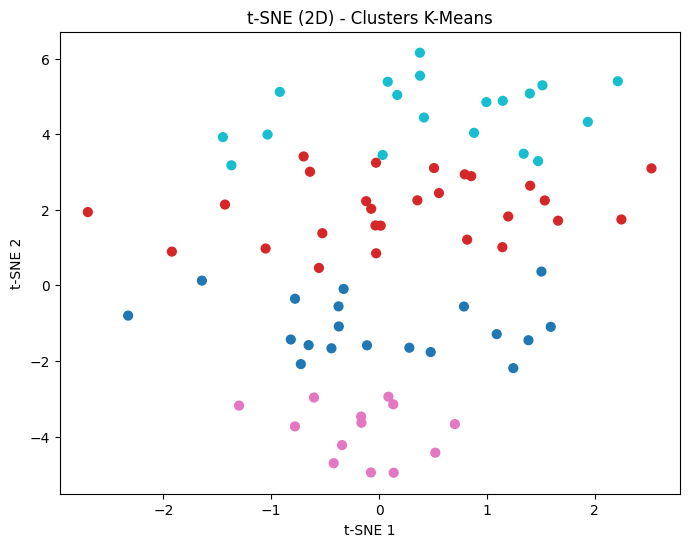

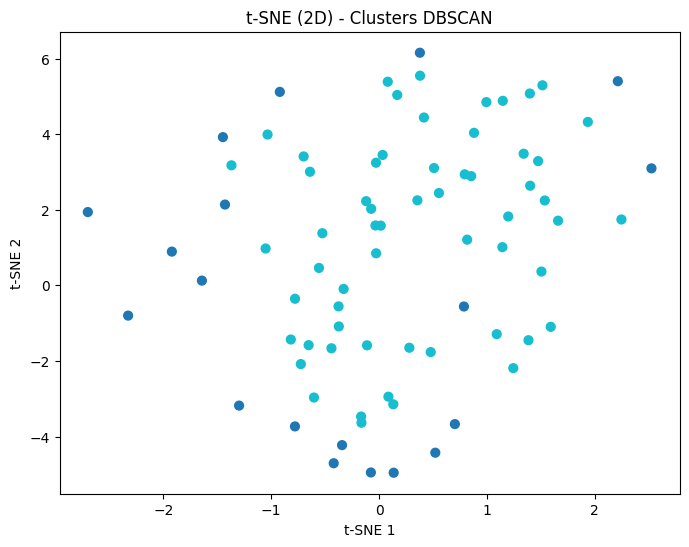

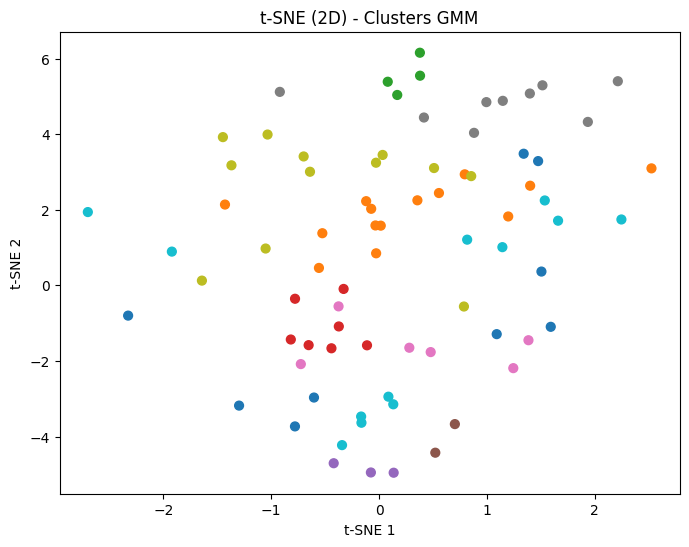

In [50]:
# Ejecutamos t-SNE para 2 componentes
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
teams_tsne = tsne.fit_transform(teams_scaled_df)

# Creamos un dataframe para graficar
df_tsne = pd.DataFrame(teams_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['KMeans'] = teams_clusters['cluster']
df_tsne['DBSCAN'] = teams_clusters_db['cluster']
df_tsne['GMM'] = teams_clusters_gmm['cluster']

# Gráfico para K-Means
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['KMeans'], cmap='tab10', s=40)
plt.title('t-SNE (2D) - Clusters K-Means')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Gráfico para DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['DBSCAN'], cmap='tab10', s=40)
plt.title('t-SNE (2D) - Clusters DBSCAN')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Gráfico para GMM
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['GMM'], cmap='tab10', s=40)
plt.title('t-SNE (2D) - Clusters GMM')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

### 3.3 UMAP (3 Pts.)

Realiza una gráfica de UMAP con 2 componentes coloreando cada dato según su cluster para los resultados obtenidos con K-Means, DBSCAN y GMM.

/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


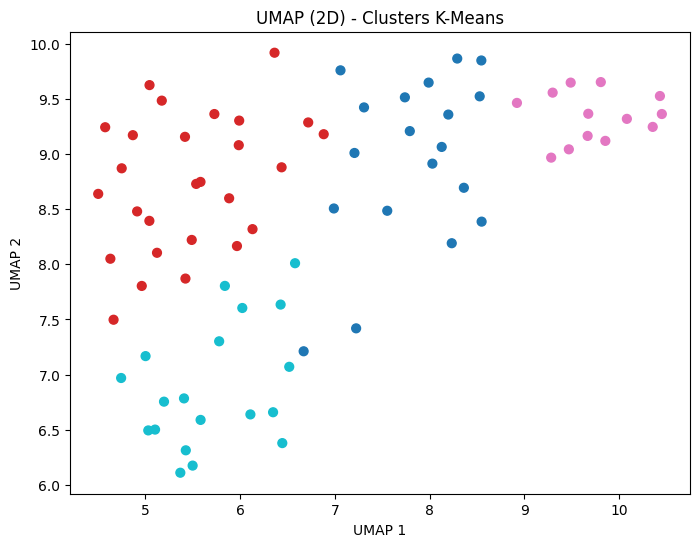

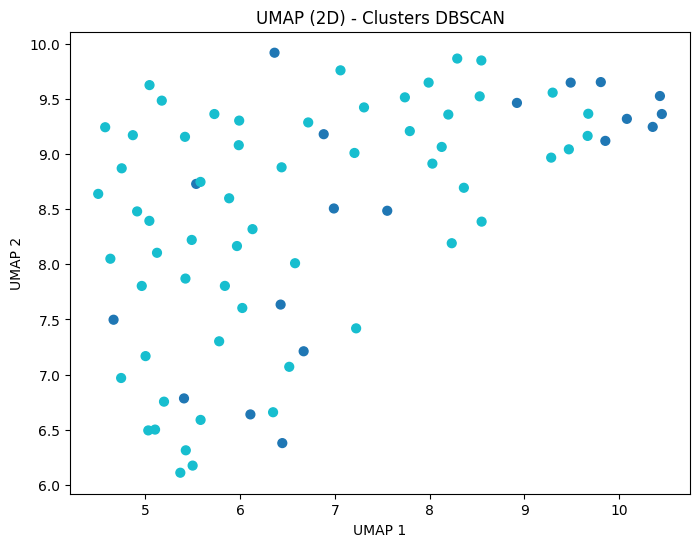

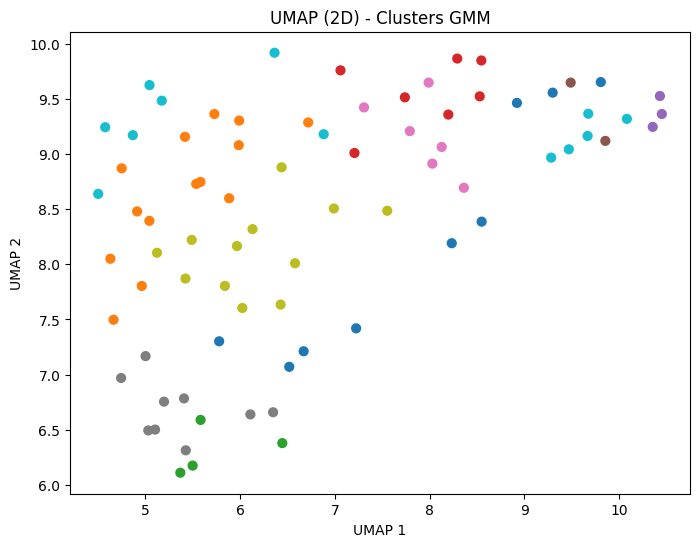

In [51]:
# Ejecutamos UMAP para 2 componentes
umap_model = UMAP(n_components=2, random_state=42)
teams_umap = umap_model.fit_transform(teams_scaled_df)

# Creamos un dataframe para graficar
df_umap = pd.DataFrame(teams_umap, columns=['UMAP1', 'UMAP2'])
df_umap['KMeans'] = teams_clusters['cluster']
df_umap['DBSCAN'] = teams_clusters_db['cluster']
df_umap['GMM'] = teams_clusters_gmm['cluster']

# Gráfico para K-Means
plt.figure(figsize=(8, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['KMeans'], cmap='tab10', s=40)
plt.title('UMAP (2D) - Clusters K-Means')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Gráfico para DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['DBSCAN'], cmap='tab10', s=40)
plt.title('UMAP (2D) - Clusters DBSCAN')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Gráfico para GMM
plt.figure(figsize=(8, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['GMM'], cmap='tab10', s=40)
plt.title('UMAP (2D) - Clusters GMM')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### 3.4 Conclusiones (2 Pts.)

En base a lo observado en los gráficos obtenidos en la sección anterior conteste:

- ¿Que método de reducción de dimensionalidad permite ver de mejor manera la agrupación de equipos?
- ¿Observaste alguna relación entre los silhoutte score obtenidos y como se visualizaron los clusters en los gráficos anteriores? ¿Qué método de clusterización se comportó mejor al graficarlo?
- ¿Existió algún cluster que se mantuvo entre las distintas técnicas de clusterización?

**Respuesta:**

La técnica de reducción de dimensionalidad que permitió ver de mejor manera la agrupación de los equipos fue UMAP. Sus gráficos muestran clusters más separados y compactos, facilitando la visualización de los grupos que se forman en comparación con PCA y t-SNE.

Además podemos ver una relación entre los silhouette scores y cómo se visualizan los clusters en los gráficos. En general, los métodos con mejor silhouette score tienden a formar agrupaciones más definidas. Los gráficos de UMAP, en particular, muestran una separación que refleja mejor la calidad de los clusters en esos casos.

El método de clusterización que se comportó mejor al graficarlo fue K-Means. Este método mostró una separación más clara y consistente en todas las técnicas de reducción de dimensionalidad, especialmente en UMAP. Por su parte, DBSCAN también logra separar algunos grupos de forma clara, dejando otros puntos como ruido, lo cual también se ve representado en los gráficos.

Al revisar las distintas técnicas, se nota que algunos clusters se mantuvieron estables. Los grupos de mejor  y peor rendimiento, se agrupan consistentemente en todos los métodos. Esto sugiere que los algoritmos de clustering lograron identificar patrones claros y extremos de rendimiento, más allá de la técnica de reducción utilizada.

## 4. Redes Bayesianas (15 Pts.)

A continuación debes realizar un análisis de redes bayesianas sobre el dataset, con la finalidad de poder inferir la probabilidad de que un equipo pertenzca a cierto grupo o no, dadas las características que se presentan en el dataset.

### 4.1 Explicación Teórica (5 Pts.)

Investiga sobre `Redes Bayesianas` y entrega una explicación de cómo funciona. `No es necesaria una explicación matemática`, el objetivo es que puedas tomar lo que aprendiste en clases o buscando en internet, y logres exponerlo de manera sintetizada para demostrar tu aprendizaje. Se espera que tu explicación contenga la respuesta a las siguientes preguntas:
1. ¿Qué es?
2. ¿Para qué sirve?
3. ¿Cómo se construye?
4. ¿Qué es un nodo y una arista en una red bayesiana?
5. ¿Qué es un CPD?

**❗IMPORTANTE❗** No utilices ChatGPT u otro modelo de lenguaje para responder esta pregunta. Será evaluado que cites al menos 1 recurso bibliográfico que hayas utilizado. Cualquier información que no tenga una referencia clara no se le dará puntaje.

**Respuesta**

Una red bayesiana es un modelo gráfico probabilístico que utiliza la teoría de la probabilidad para modelar lo desconocido. Muestra la relación entre nodos (variables) y resultados, determinando si las variables son dependientes o independientes. Además, permite observar un suceso y sugerir las posibles variables que lo han provocado, ofreciendo información sobre las probabilidades relativas a las causas y efectos de los acontecimientos (https://thedecisionlab.com/es/reference-guide/statistics/bayesian-network)

Sirve para predecir relaciones causa-efecto en entornos de incertidumbre. Las redes bayesianas permiten hacer inferencias fundamentadas sobre las probabilidades de distintos resultados, integrando múltiples variables en la elaboración de hipótesis y ajustando esas hipótesis a medida que se recopila más información. (https://thedecisionlab.com/es/reference-guide/statistics/bayesian-network)

Se construye a partir de grafos acíclicos dirigidos que muestran las relaciones causales entre variables, asumiendo que las relaciones son unidireccionales y sin bucles de retroalimentación. Los nodos padres influyen en sus descendientes, pero no se afectan entre sí. Esto se basa en la condición de Markov, que establece que los nodos padres son independientes de sus nodos descendientes. (https://thedecisionlab.com/es/reference-guide/statistics/bayesian-network)

En una red bayesiana, un nodo representa una variable aleatoria. Esta variable puede ser discreta, como la presencia o ausencia de una enfermedad, o continua, como la temperatura de un paciente. Por otro lado, una arista (o flecha) es una conexión dirigida entre dos nodos que indica una dependencia probabilística. Cuando hay una flecha de un nodo A a un nodo B, esto significa que A tiene una influencia directa sobre B. El grafo que se forma con nodos y aristas es acíclico, lo que significa que no se puede seguir un camino de flechas que regrese al nodo de inicio. (https://www.ultralytics.com/es/glossary/bayesian-network)

El CPD, si una variable aleatoria tiene padres en la red, representa la probabilidad de esa variable dado sus padres, en cambio, si la variable no tiene padres, el CPD simplemente representa la probabilidad a priori de la variable. (https://causalnex.readthedocs.io/en/latest/04_user_guide/04_user_guide.html)



### 4.2 Aprender la estructura de la red bayesiana (3 Pts.)

Del DataFrame original, elimine la columna `team`.
Luego, utilice la librería pgmpy en Python para aplicar el algoritmo Hill Climb Search con el criterio de puntuación BDs y encontrar la estructura óptima de una red bayesiana. Puedes guiarte de las actividades vistas en clases.

(Sugerencia: la clase `BDs` se importa de forma simiar a `BIC`, es decir, `from pgmpy.estimators import BDs`)

In [57]:
# Eliminamos la columna 'team' del DataFrame original
teams_no_team = teams.drop(columns=['team'])

# Hacemos HillClimbSearch con el DataFrame nuevo
hc = HillClimbSearch(teams_no_team)

# Usamos el criterio BDs para buscar la mejor estructura
best_model = hc.estimate(scoring_method=BDs(teams_no_team))
print("Arcos aprendidos en la red bayesiana")
print(best_model.edges())


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Unnamed: 0': 'N', 'total_shots': 'N', 'onTarget': 'N', 'goals': 'N', 'xG_total': 'N', 'Shot_to_goal_ratio': 'N', 'Shot_onTarget_to_goal_ratio': 'N', 'xG/shot': 'N', 'recoveries': 'N', 'recoveries_f3': 'N', 'duels_won': 'N', 'fouls_committed': 'N', 'shots_against': 'N', 'shots_onTarget_against': 'N', 'xGA': 'N', 'goals_against': 'N', 'clean_sheets': 'N', 'ppda': 'N', 'total_passes': 'N', 'f3_passes': 'N', 'short_passes': 'N', 'long_passes': 'N', 'average_pass_length': 'N', 'crosses': 'N', 'ranking': 'N', 'points_per_match': 'N', 'groups': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Unnamed: 0': 'N', 'total_shots': 'N', 'onTarget': 'N', 'goals': 'N', 'xG_total': 'N', 'Shot_to_goal_ratio': 'N', 'Shot_onTarget_to_goal_ratio': 'N', 'xG/shot': 'N', 'recoveries': 'N', 'recoveries_f3': 'N', 'duels_won': 'N', 'fouls_commit

Arcos aprendidos en la red bayesiana
[('Unnamed: 0', 'fouls_committed'), ('xG_total', 'f3_passes'), ('xG_total', 'points_per_match'), ('Shot_to_goal_ratio', 'average_pass_length'), ('Shot_to_goal_ratio', 'total_shots'), ('Shot_onTarget_to_goal_ratio', 'Shot_to_goal_ratio'), ('xG/shot', 'duels_won'), ('xG/shot', 'shots_onTarget_against'), ('xGA', 'crosses'), ('ppda', 'Unnamed: 0'), ('ppda', 'shots_against'), ('ppda', 'recoveries_f3'), ('ppda', 'onTarget'), ('total_passes', 'short_passes'), ('total_passes', 'ppda'), ('total_passes', 'xG/shot'), ('short_passes', 'xGA'), ('short_passes', 'xG_total'), ('short_passes', 'long_passes'), ('short_passes', 'recoveries'), ('short_passes', 'goals'), ('short_passes', 'goals_against'), ('average_pass_length', 'total_passes'), ('points_per_match', 'groups'), ('groups', 'ranking'), ('groups', 'clean_sheets')]


### 4.3 Encontrar la estructura óptima (2 Pts.)

En esta sección, debes entrenar la red bayesiana con los datos de entrenamiento usando la estructura óptima encontrada en la sección anterior, ajustando los parámetros usando priors de Dirichlet con cuentas uniformes. Luego, debes imprimir las probabilidades condicionales de la red bayesiana.

In [65]:
# Creamos la red bayesiana con la estructura óptima
model = DiscreteBayesianNetwork(best_model.edges())

# Ajustamos los parámetros usando priors de Dirichlet con cuentas uniformes (pseudo counts igual a 1 es lo mismo que uniforme)
model.fit(teams_no_team, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)
# Imprimimos las probabilidades condicionales
print("Probabilidades condicionales de la red bayesiana:")
for cpd in model.get_cpds():
    print(cpd)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Unnamed: 0': 'N', 'total_shots': 'N', 'onTarget': 'N', 'goals': 'N', 'xG_total': 'N', 'Shot_to_goal_ratio': 'N', 'Shot_onTarget_to_goal_ratio': 'N', 'xG/shot': 'N', 'recoveries': 'N', 'recoveries_f3': 'N', 'duels_won': 'N', 'fouls_committed': 'N', 'shots_against': 'N', 'shots_onTarget_against': 'N', 'xGA': 'N', 'goals_against': 'N', 'clean_sheets': 'N', 'ppda': 'N', 'total_passes': 'N', 'f3_passes': 'N', 'short_passes': 'N', 'long_passes': 'N', 'average_pass_length': 'N', 'crosses': 'N', 'ranking': 'N', 'points_per_match': 'N', 'groups': 'N'}


Probabilidades condicionales de la red bayesiana:
+----------------+-----+--------------------------+
| ppda           | ... | ppda(20.223516023509195) |
+----------------+-----+--------------------------+
| Unnamed: 0(0)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(1)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(2)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(3)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(4)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(5)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(6)  | ... | 0.012658227848101266     |
+----------------+-----+--------------------------+
| Unnamed: 0(7)  | ... | 0.012658227848101266     |
+-------------

### 4.4 Inferencia sobre los datos (5 Pts.)

Finalmente, debes realizar inferencia sobre la red bayesiana. Para esto, se te pide que calcules la probabilidad de que un equipo pertenezca al grupo `groups` dadas las siguientes características

- Equipo 1: 'fouls_committed': 706, 'duels_won': 433
- Equipo 2: 'total_shots': 439, 'total_passes': 15919
- Equipo 3: 'goals': 80, 'goals_against': 51, 'onTarget': 137

¿Que limitaciones cree que tiene este modelo para el problema?

In [61]:
# moto de inferencia
infer = VariableElimination(model)

# calculamos la probabilidad de que un equipo pertenezca al grupo `groups` dadas las siguientes características
prob = infer.query(variables=['groups'], evidence={'fouls_committed': 706, 'duels_won': 433})
print(prob)

# calculamos la probabilidad de que un equipo pertenezca al grupo `groups` dadas las siguientes características
prob = infer.query(variables=['groups'], evidence={'total_shots': 439, 'total_passes': 15919})
print(prob)

# calculamos la probabilidad de que un equipo pertenezca al grupo `groups` dadas las siguientes características
prob = infer.query(variables=['groups'], evidence={'goals': 80, 'goals_against': 51, 'onTarget': 137})
print(prob)


+-----------+---------------+
| groups    |   phi(groups) |
+===========+===============+
| groups(1) |        0.2607 |
+-----------+---------------+
| groups(2) |        0.2522 |
+-----------+---------------+
| groups(3) |        0.2439 |
+-----------+---------------+
| groups(4) |        0.2432 |
+-----------+---------------+
+-----------+---------------+
| groups    |   phi(groups) |
+===========+===============+
| groups(1) |        0.2607 |
+-----------+---------------+
| groups(2) |        0.2522 |
+-----------+---------------+
| groups(3) |        0.2439 |
+-----------+---------------+
| groups(4) |        0.2432 |
+-----------+---------------+
+-----------+---------------+
| groups    |   phi(groups) |
+===========+===============+
| groups(1) |        0.2607 |
+-----------+---------------+
| groups(2) |        0.2522 |
+-----------+---------------+
| groups(3) |        0.2439 |
+-----------+---------------+
| groups(4) |        0.2432 |
+-----------+---------------+


**Respuesta:**

El modelo de red bayesiana tiene limitaciones al momento de predecir la probabilidad de que un equipo pertenezca a cierto grupo o no, dadas las características que se presentan en el dataset.

Esto principalmente ya que en primer lugar contamos con un dataset que no es lo suficientemente grande como para poder hacer una buena inferencia, ya que solo contamos con 78 equipos en el dataset, de esta forma tener una red bayesiana con varias combinaciones de datos sin rellenar que son reemplazadas con conteos uniformes, lo que genera una red incompleta y no necesariamente acorde a la realidad.

Además estamos tratando algunos datos continuos para una red Discreta, lo que genera que no se pueda hacer una buena inferencia, ya que los datos no son discretos y no se puede asignar una probabilidad a cada uno de los datos.






## 5. Asociaciones (15 Pts.)

Debido a tu gran desempeño en tu labor anterior detectando los distintos tipos de equipos en las 5 grandes ligas de fútbol, el empresario multimillonario te quiere encargar una nueva misión. Se ha enterado que el último campéon de la Eurocopa ha sido España, por lo que quiere fichar jugadores de esta selección que se relacionen bien entre ellos para poder ficharlos. Para conseguir lo anterior, te ha entregado un dataset con las secuencias de pases de los jugadores de la Selección Española durante sus partidos en la Eurocopa 2024 y tu labor será encontrar los jugadores que mejor se asocian.

Una secuencia de pases se entiende como todos los jugadores que se dieron pases entre ellos antes de que el equipo haya perdido el balón o el juego se haya detenido por algún motivo. El dataset contiene lineas con los nombres de los jugadores que participaron en una secuencia de pases separados por ;.

### 5.1 Cargar Datos (2 Pts.)

Carga el dataset `passes.csv` y dejando los datos como una lista de listas.

In [71]:
# Archivo a df
passes_df = pd.read_csv('passes.csv', header=None)

# Convertimos cada fila en una lista separando por ';'
passes = [ row[0].split(';') for row in passes_df.values.tolist() ]

print(passes)

[['Dani Carvajal', 'Álvaro Morata'], ['Nacho Fernández', 'Marc Cucurella', 'Robin Le Normand', 'Unai Simón', 'Fabián Ruiz'], ['Fabián Ruiz', 'Álvaro Morata', 'Marc Cucurella'], ['Lamine Yamal', 'Robin Le Normand', 'Rodri', 'Nacho Fernández', 'Dani Carvajal', 'Fabián Ruiz'], ['Dani Carvajal', 'Pedri'], ['Nacho Fernández', 'Pedri'], ['Rodri', 'Nacho Fernández', 'Marc Cucurella', 'Robin Le Normand', 'Unai Simón'], ['Robin Le Normand', 'Unai Simón', 'Marc Cucurella'], ['Dani Carvajal', 'Unai Simón', 'Nacho Fernández', 'Marc Cucurella'], ['Fabián Ruiz', 'Marc Cucurella'], ['Lamine Yamal', 'Fabián Ruiz'], ['Fabián Ruiz', 'Pedri'], ['Robin Le Normand', 'Rodri', 'Nacho Fernández'], ['Robin Le Normand', 'Rodri', 'Dani Carvajal'], ['Lamine Yamal', 'Robin Le Normand', 'Rodri', 'Nacho Fernández', 'Marc Cucurella', 'Dani Carvajal'], ['Dani Carvajal', 'Rodri', 'Nacho Fernández', 'Robin Le Normand'], ['Rodri', 'Nacho Fernández', 'Robin Le Normand', 'Dani Carvajal', 'Fabián Ruiz'], ['Fabián Ruiz', 'Da

### 5.2 Mostrar frecuencia (3 Pts.)

A continuación debes mostrar la frecuencia de participación de los jugadores en las secuencias de pases ordenadas de manera descendente.

In [75]:
# Creamos una lista plana con todos los jugadores
all_players = [player for seq in passes for player in seq]

# Contamos la frecuencia de participación de cada jugador
player_freq = pd.Series(all_players).value_counts()

# Mostrar los resultados ordenados de forma descendente
print("Frecuencia de participación de los jugadores (orden descendente):")
print(player_freq)

Frecuencia de participación de los jugadores (orden descendente):
Rodri                 442
Fabián Ruiz           437
Aymeric Laporte       375
Marc Cucurella        340
Dani Carvajal         311
Robin Le Normand      280
Nico Williams         268
Lamine Yamal          247
Dani Olmo             223
Unai Simón            211
Álvaro Morata         150
Mikel Merino          146
Nacho Fernández       140
Pedri                 135
Martín Zubimendi       97
Mikel Oyarzabal        85
Alejandro Grimaldo     84
Jesús Navas            74
Daniel Vivian          72
Ferran Torres          58
David Raya             33
Joselu                 21
Alejandro Baena        18
Fermin Lopez           15
Ayoze Pérez             8
Name: count, dtype: int64


### 5.3 Transformar datos (3 Pts)

Utiliza `TransactionEncoder()` para codificar las secuencias de pases en vectores.

In [78]:
# instanciando TransactionEncoder
te = TransactionEncoder()

# transformando los datos
te_ary = te.fit(passes).transform(passes)

# creando un df
df = pd.DataFrame(te_ary, columns=te.columns_)

# mostramos el df
print("Matriz codificada")
print(df.head())


Matriz codificada
   Alejandro Baena  Alejandro Grimaldo  Aymeric Laporte  Ayoze Pérez  \
0            False               False            False        False   
1            False               False            False        False   
2            False               False            False        False   
3            False               False            False        False   
4            False               False            False        False   

   Dani Carvajal  Dani Olmo  Daniel Vivian  David Raya  Fabián Ruiz  \
0           True      False          False       False        False   
1          False      False          False       False         True   
2          False      False          False       False         True   
3           True      False          False       False         True   
4           True      False          False       False        False   

   Fermin Lopez  ...  Martín Zubimendi  Mikel Merino  Mikel Oyarzabal  \
0         False  ...             False         Fa

### 5.4 Matriz de co-ocurrencia (2 Pts.)

Genera la matriz de co-ocurrencia para observar con qué frecuencia los jugadores participan entre sí en las secuencias de pases. En base a la matriz contesta las siguientes preguntas:

- ¿Qué jugadores se observa que estan relacionados?
- Revisando las formaciones de España durante la Eurocopa, ¿se observa alguna relación entre las posiciones en el campo y los jugadores con mayor relación entre ellos?

[España v/s Croacia](https://www.sofascore.com/football/match/croatia-spain/YTbspUb#id:11873907)

[España v/s Italia](https://www.sofascore.com/football/match/italy-spain/YTbshUb#id:11873901)

[España v/s Albania](https://www.sofascore.com/football/match/spain-albania/PTbsYTb#id:11873904)

[España v/s Georgia](https://www.sofascore.com/football/match/georgia-spain/YTbsnVb#id:11874031)

[España v/s Alemania](https://www.sofascore.com/football/match/germany-spain/YTbslUb#id:11874027)

[España v/s Francia](https://www.sofascore.com/football/match/germany-spain/YTbslUb#id:11874027)

[España v/s Inglaterra](https://www.sofascore.com/football/match/england-spain/YTbsnUb#id:11874023)

In [79]:
# Generamos la matriz de co-ocurrencia
co_occurrence_matrix = df.T.dot(df)

# Mostramos las primeras filas para ver cómo quedó
print("Matriz de co-ocurrencia de los jugadores:")
print(co_occurrence_matrix)

Matriz de co-ocurrencia de los jugadores:
                    Alejandro Baena  Alejandro Grimaldo  Aymeric Laporte  \
Alejandro Baena                True                True             True   
Alejandro Grimaldo             True                True             True   
Aymeric Laporte                True                True             True   
Ayoze Pérez                    True               False             True   
Dani Carvajal                  True                True             True   
Dani Olmo                     False                True             True   
Daniel Vivian                  True                True             True   
David Raya                     True                True             True   
Fabián Ruiz                    True                True             True   
Fermin Lopez                   True                True            False   
Ferran Torres                  True                True             True   
Jesús Navas                   False           

**Respuesta**

Al ver la matriz de co ocurrencia podemos ver que los jugadores que más se relacionan tienen directa relación con la cercanía en el campo de juego y obviamente con la pertenencia al mismo equipo, por lo que podemos decir que en general que los jugadores con más cercanía en el campo de juego, tienden a tener mayor co ocurrencia en los eventos de la secuencia de pases.

### 5.5 Algoritmo a-priori (5 Pts.)

Aplica el algoritmo Apriori con min_support=0.1 y analiza los resultados obtenidos.

In [80]:
# Aplicamos Apriori con un soporte mínimo de 0.1
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

# Ordenamos los resultados por soporte descendente
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

# Mostramos los resultados
print("Conjuntos frecuentes encontrados:")
print(frequent_itemsets)

Conjuntos frecuentes encontrados:
     support                           itemsets
11  0.334089                            (Rodri)
3   0.330310                      (Fabián Ruiz)
0   0.283447                  (Aymeric Laporte)
5   0.256992                   (Marc Cucurella)
1   0.235072                    (Dani Carvajal)
10  0.211640                 (Robin Le Normand)
8   0.202570                    (Nico Williams)
4   0.186697                     (Lamine Yamal)
2   0.168556                        (Dani Olmo)
12  0.159486                       (Unai Simón)
19  0.136054               (Rodri, Fabián Ruiz)
16  0.121693           (Rodri, Aymeric Laporte)
15  0.120937  (Marc Cucurella, Aymeric Laporte)
13  0.113379                    (Álvaro Morata)
18  0.113379      (Marc Cucurella, Fabián Ruiz)
6   0.110355                     (Mikel Merino)
20  0.109599            (Marc Cucurella, Rodri)
14  0.108844     (Fabián Ruiz, Aymeric Laporte)
7   0.105820                  (Nacho Fernández)
9   0.

**Respuesta**

El análisis con el algoritmo Apriori, usando un soporte mínimo del 10%, nos permite identificar qué jugadores participaron más frecuentemente en las secuencias de pase. Entre los jugadores más presentes destacan Rodri (33%), Fabián Ruiz (33%) y Aymeric Laporte (28%), etc, lo que significa que de por si, ellos solos tienen una alta presencia en el juego de la selección y por lo tanto, son jugadores que se destacan en el juego activamente.

Además, se identificaron asociaciones entre pares de jugadores que aparecen juntos en las jugadas. Por ejemplo, Rodri y Fabián Ruiz están en un 13,6% de las secuencias, esto refleja la estructura de juego de la selección española, donde Rodri es fundamental como organizador y sus otros compañeros que presenta co ocurrencia son claves para tener un juego de pases efectivos, por lo que es buena idea que jueguen juntos.

Estos resultados muestran claramente las asociaciones más importantes en el juego de la selección y permiten identificar a los jugadores más vinculados en las jugadas. Lo que, complementado a otro tipo de análisis, es un buen punto de partida para poder tomar decisiones sobre fichajes o estrategias.

A continuación, genera las reglas de asociación utilizando association_rules, con un umbral min_threshold=0.3, y en base a los resultados obtenidos conteste las siguientes preguntas:

- ¿Qué par de jugadores recomendaría que se ficharan juntos?
- ¿Crees que este método es suficiente para recomendar fichaje de jugadores? ¿Por qué?

In [81]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)

# Ordenamos por confianza descendente para ver las reglas más fuertes
rules_sorted = rules.sort_values(by='confidence', ascending=False)

# Mostramos las reglas
print("Reglas de asociación con confianza >= 0.3:")
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Reglas de asociación con confianza >= 0.3:
          antecedents        consequents   support  confidence      lift
4    (Marc Cucurella)  (Aymeric Laporte)  0.120937    0.470588  1.660235
6    (Marc Cucurella)      (Fabián Ruiz)  0.113379    0.441176  1.335644
3   (Aymeric Laporte)            (Rodri)  0.121693    0.429333  1.285086
13    (Dani Carvajal)            (Rodri)  0.100529    0.427653  1.280056
5   (Aymeric Laporte)   (Marc Cucurella)  0.120937    0.426667  1.660235
8    (Marc Cucurella)            (Rodri)  0.109599    0.426471  1.276517
1       (Fabián Ruiz)            (Rodri)  0.136054    0.411899  1.232902
0             (Rodri)      (Fabián Ruiz)  0.136054    0.407240  1.232902
11  (Aymeric Laporte)      (Fabián Ruiz)  0.108844    0.384000  1.162545
2             (Rodri)  (Aymeric Laporte)  0.121693    0.364253  1.285086
7       (Fabián Ruiz)   (Marc Cucurella)  0.113379    0.343249  1.335644
10      (Fabián Ruiz)  (Aymeric Laporte)  0.108844    0.329519  1.162545
9       

**Respuesta**

En base al resultado anterior, las reglas de asociación encontradas, el par Marc Cucurella y Aymeric Laporte destaca con una confianza del 47% y un lift de 1.66, lo que significa que este par de jugadores tienden a aparecer juntos en las secuencias de pases y que es un buen fichaje para la selección. Por otra parte el  par destacado es Marc Cucurella y Fabián Ruiz con una confianza del 44%, lo que indica  que estos jugadores están muy conectados en sus dinámicas y pueden ser una buena combinación.

No obstante, aunque el análisis con Apriori y reglas de asociación muestra qué jugadores tienen conexiones frecuentes en jugadas, no considera aspectos clave como las posiciones, la cantidad de exposición que tiene a tener pases unos jugadores con otros, la tase de pases errados entre el duo y otros aspectos técnicos propios de un análisis con mayor conocimiento deportivo. 

De esta manera, para poder tomar decisiones sobre fichajes, se recomienda complementar este análisis con la revisión de los partidos y un entendimiento más táctico de sus roles en el campo.

**Anexo**

Las fuentes adicionales que se utilizaron para la realización de esta tarea son:

- Slides del curso
- Documentación de las librerias
- Codigo de actividades del curso
- Copilot para la escritura del codigo, en particular con el trabajo más sistemático.